In [1]:
import re
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime
from nltk.sentiment import SentimentIntensityAnalyzer
from random import shuffle
from sklearn import preprocessing
from time import strptime
from wordcloud import WordCloud, STOPWORDS

reddit = pd.read_csv('./Datasets/reddit_wsb.csv')

#data cleaning 

reddit['title'] = reddit['title'].str.lower()

english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)

def remove_tags(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt 

reddit['title'] = np.vectorize(remove_tags)(reddit['title'], "@[\w]*")
reddit['title'] = reddit['title'].apply(lambda x: cleaning_URLs(x))
reddit['title']= reddit['title'].apply(lambda x: cleaning_punctuations(x))


#filtering out relevant data - just the thread and timestamp 

reddit = reddit[ ['title', 'timestamp']]


#getting the date, remove the time. the type is in string. hence, manual extraction
for i in range(len(reddit)): 
    reddit['timestamp'][i] = reddit['timestamp'][i][0:11]

In [2]:
reddit

,title,timestamp
0,its not about the money its about sending a me...,2021-01-28
1,math professor scott steiner says the numbers ...,2021-01-28
2,exit the system,2021-01-28
3,new sec filing for gme can someone less retard...,2021-01-28
4,not to distract from gme just thought our amc ...,2021-01-28
...,...,...
53182,what i learned investigating sava fud spreaders,2021-08-02
53183,daily popular tickers thread for august 02 202...,2021-08-02
53184,hitler reacts to the market being irrational,2021-08-02
53185,daily discussion thread for august 02 2021,2021-08-02


In [3]:
#filter out relevant words => did not filter out specific words since all from a specialised thread


#conducting sentiment analysis using VADER model 
sia = SentimentIntensityAnalyzer()

reddit['negative'] = 0
reddit['positive'] = 0
reddit['neutral'] = 0
reddit['compound'] = 0
reddit['sentiment'] = 0



for i in range(len(reddit['title'])):
    sentence = reddit['title'][i]
    reddit.loc[i, 'negative']= sia.polarity_scores(sentence).get('neg')
    reddit.loc[i, 'positive']= sia.polarity_scores(sentence).get('pos')
    reddit.loc[i, 'neutral']= sia.polarity_scores(sentence).get('neu')
    reddit.loc[i, 'compound']= sia.polarity_scores(sentence).get('compound')

    if sia.polarity_scores(sentence).get('compound') > 0: 
        reddit.loc[i, 'sentiment'] = 1
    elif sia.polarity_scores(sentence).get('compound') == 0: 
        reddit.loc[i, 'sentiment'] = 0
    else: 
        reddit.loc[i, 'sentiment'] = -1
        
reddit[500:800]

,title,timestamp,negative,positive,neutral,compound,sentiment
500,robinhood just started ww3,2021-01-28,0.000,0.000,1.000,0.0000,0
501,fuck you robinhood,2021-01-28,0.636,0.000,0.364,-0.5423,-1
502,this is an online protest on the fucking marke...,2021-01-28,0.242,0.000,0.758,-0.6249,-1
503,srne we are sick of stockroaches hitting this ...,2021-01-28,0.076,0.143,0.782,0.4404,1
504,get fricked lol,2021-01-28,0.000,0.583,0.417,0.4215,1
...,...,...,...,...,...,...,...
795,buy more never sell,2021-01-28,0.000,0.000,1.000,0.0000,0
796,if you have a minute go and rate robinhood 1 s...,2021-01-28,0.064,0.149,0.787,0.4404,1
797,rh not letting ppl purchase gme amc nok the li...,2021-01-28,0.000,0.000,1.000,0.0000,0
798,what’s hapenning,2021-01-28,0.000,0.000,1.000,0.0000,0


In [4]:
#group the threads within dates to get the numbers out

column_names = ["date", "number", "avg"]
redditnumber = pd.DataFrame(columns = column_names)
                            
sumcpd = 0 
length = 1
counter = 0 
                            
for i in range(len(reddit) - 1):
    if ((reddit.loc[i, 'timestamp']) == (reddit.loc[i+1, 'timestamp'])):
        sumcpd += reddit.loc[i, 'compound']
        length += 1
    
    else: 
        
        counter += 1
        
        #extract the dates to aggregate 
        redditnumber.loc[counter, 'date'] = pd.to_datetime(reddit.loc[i, 'timestamp']).date()
        redditnumber.loc[counter, 'avg'] = float(sumcpd/length)
       
        #extract the sentiment score 
        sumcpd += reddit.loc[i, 'compound']
        redditnumber.loc[counter, 'avg'] = float(sumcpd/length)
        redditnumber.loc[counter, 'number'] = length
        
        sumcpd = 0 
        length = 1                        



redditnumber[500:550]

,date,number,avg
501,2021-05-20,33,0.0051
502,2021-05-19,49,0.14771
503,2021-05-18,71,0.092577
504,2021-05-17,28,-0.000882
505,2021-05-16,21,0.089043
506,2021-05-15,73,0.0963
507,2021-05-14,110,0.102239
508,2021-05-13,101,0.087539
509,2021-05-12,65,0.083551
510,2021-05-30,2,-0.3825


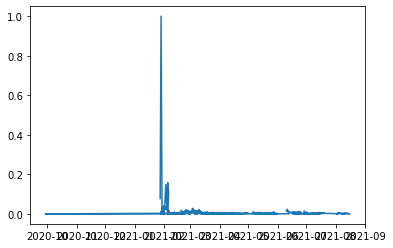

In [5]:
def normalize_data(df):
    minimum = min(df)
    maximum = max(df)
    x = df 
    y = (x - minimum) / (maximum  - minimum)
    return y


x = redditnumber['date']

avg = normalize_data(redditnumber['avg'])
number = normalize_data(redditnumber['number'])

plt.plot(x, number)

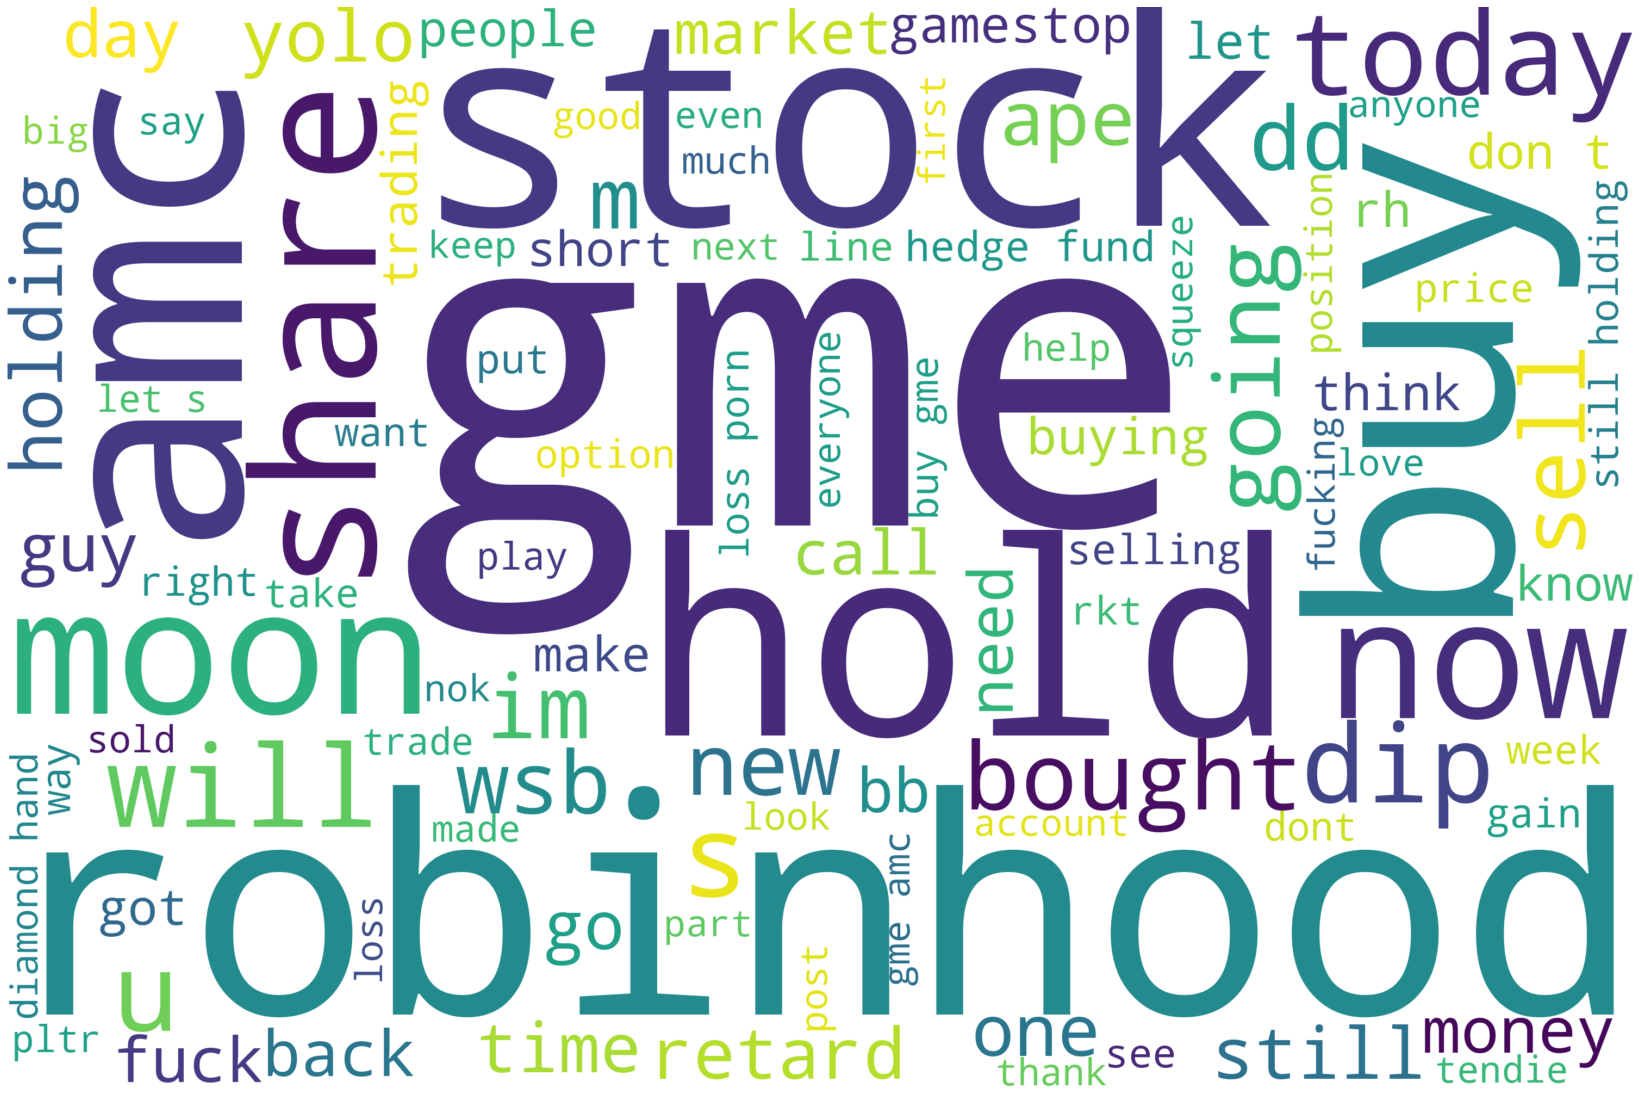

In [6]:
text = " ".join(title for title in reddit['title'])

# Generates a word cloud image
wordcloud = WordCloud(width = 3000, height = 2000, background_color = "white", 
                      max_words = 100, stopwords = STOPWORDS).generate(text)

# Displays the wordcloud image
plt.figure(figsize = (30,20))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()